In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from skimage import io, transform
from tqdm import tqdm

In [2]:
import os
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

In [3]:
%cd '/content/drive/MyDrive/CV_ENG_8160/Data/traffic_sign'

/content/drive/MyDrive/CV_ENG_8160/Data/traffic_sign


In [4]:
import os
print (len(os.listdir('00029')))

290


In [5]:
class traffic_sign(Dataset):
    def __init__(self, root_dir ):

        # initialize dataset variables here
        # self.root = root_dir
        self.root = Path(root_dir)

        self.df = pd.DataFrame(columns = ['image_names','class_label'])

        for fldr in self.root.iterdir():
          img_names = []
          if fldr.is_dir():
            img_names = img_names + list(fldr.glob('*.ppm'))

          img_names = [i for i in img_names]
          df_cur = pd.DataFrame(img_names,columns = ['image_names'])
          df_cur['class_label'] = fldr.name
          self.df = pd.concat([self.df, df_cur],axis=0)

        self.df = self.df.sample(frac=0.1)
        self.image_names = list(self.df['image_names'].values)
        self.class_label = list(self.df['class_label'].values)

        self.df = pd.concat([self.df, pd.get_dummies(self.df['class_label'])], axis=1)
        self.label_columns = self.df.columns[2:]

    def __len__(self):
        # returns the length of the dataset
        return len(self.image_names)

    def __getitem__(self, idx):

        # preprocess and transformations
        # indexes the dataset such that dataset[i] can retrieve the ith sample.
        image = self.image_names[idx]
        # scale = Rescale(256)
        image_data = io.imread(image)
        # image_np = Image.fromarray(image_data)

        label = self.df.iloc[idx][self.label_columns].values.astype(float)

        sample = {'image': image_data, 'label': label}
        scale = Rescale((64,64))
        sample = scale(sample)

        to_tensor = ToTensor()
        sample = to_tensor(sample)

        return sample

In [8]:
## transform data
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, labels = sample['image'], sample['label']

        h, w = image.shape[:2]

        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return {'image': img, 'label': labels}

In [9]:
class ToTensor(object):
    def __call__(self, sample):
        input, output = sample['image'], sample['label']

        input_tensor = torch.tensor(np.array(input), dtype=torch.float32)

        output_tensor = torch.tensor(output, dtype=torch.float32)

        return {'image': input_tensor, 'label': output_tensor}


In [10]:
traffic_sign_dataset = traffic_sign('/content/drive/MyDrive/CV_ENG_8160/Data/traffic_sign')

In [11]:
for i, sample in enumerate(traffic_sign_dataset):
  print(i, sample['image'].shape, sample['label'])
  if i == 3:
    break

0 torch.Size([64, 64, 3]) tensor([1., 0., 0., 0., 0., 0., 0.])
1 torch.Size([64, 64, 3]) tensor([0., 1., 0., 0., 0., 0., 0.])
2 torch.Size([64, 64, 3]) tensor([1., 0., 0., 0., 0., 0., 0.])
3 torch.Size([64, 64, 3]) tensor([0., 1., 0., 0., 0., 0., 0.])


In [13]:
print (sample['image'].shape)

torch.Size([64, 64, 3])


In [14]:
## how will we add softmax to this
model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(12288, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 7),
        nn.Softmax(dim=1)
        )
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=12288, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=64, bias=True)
  (6): ReLU()
  (7): Linear(in_features=64, out_features=7, bias=True)
  (8): Softmax(dim=1)
)

In [18]:
bs = 128

dataloader = DataLoader(traffic_sign_dataset, batch_size=bs, shuffle=True, num_workers=4,drop_last=True)


In [17]:
criterion = nn.CrossEntropyLoss()
# criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [19]:
mean_loss = []
losses = []
n_epochs = 20
for it in tqdm(range(n_epochs)):
  # zero the parameter gradients
  for i_batch, sample_batched in enumerate(dataloader):
    optimizer.zero_grad()
    outputs = model(sample_batched['image'])
    loss = criterion(outputs, sample_batched['label'])
    losses.append(loss.item())
    # print (loss)

    loss.backward()
    optimizer.step()
  mean_loss.append(np.mean(losses))
  print(f'Epoch {it+1}/{n_epochs}, Training Loss: {np.mean(losses):.4f}')


  5%|▌         | 1/20 [00:39<12:29, 39.44s/it]

Epoch 1/20, Training Loss: 1.9397


 10%|█         | 2/20 [00:51<06:59, 23.32s/it]

Epoch 2/20, Training Loss: 1.9291


 15%|█▌        | 3/20 [00:56<04:15, 15.04s/it]

Epoch 3/20, Training Loss: 1.9161


 20%|██        | 4/20 [01:00<02:50, 10.66s/it]

Epoch 4/20, Training Loss: 1.9046


 25%|██▌       | 5/20 [01:05<02:06,  8.42s/it]

Epoch 5/20, Training Loss: 1.8953


 30%|███       | 6/20 [01:08<01:33,  6.70s/it]

Epoch 6/20, Training Loss: 1.8912


 35%|███▌      | 7/20 [01:11<01:12,  5.58s/it]

Epoch 7/20, Training Loss: 1.8872


 40%|████      | 8/20 [01:17<01:06,  5.56s/it]

Epoch 8/20, Training Loss: 1.8840


 45%|████▌     | 9/20 [01:22<00:59,  5.45s/it]

Epoch 9/20, Training Loss: 1.8808


 50%|█████     | 10/20 [01:25<00:48,  4.82s/it]

Epoch 10/20, Training Loss: 1.8796


 55%|█████▌    | 11/20 [01:29<00:39,  4.36s/it]

Epoch 11/20, Training Loss: 1.8763


 60%|██████    | 12/20 [01:33<00:36,  4.50s/it]

Epoch 12/20, Training Loss: 1.8727


 65%|██████▌   | 13/20 [01:37<00:29,  4.15s/it]

Epoch 13/20, Training Loss: 1.8691


 70%|███████   | 14/20 [01:40<00:23,  3.94s/it]

Epoch 14/20, Training Loss: 1.8667


 75%|███████▌  | 15/20 [01:43<00:18,  3.69s/it]

Epoch 15/20, Training Loss: 1.8639


 80%|████████  | 16/20 [01:48<00:16,  4.08s/it]

Epoch 16/20, Training Loss: 1.8605


 85%|████████▌ | 17/20 [01:52<00:11,  3.85s/it]

Epoch 17/20, Training Loss: 1.8570


 90%|█████████ | 18/20 [01:55<00:07,  3.67s/it]

Epoch 18/20, Training Loss: 1.8530


 95%|█████████▌| 19/20 [01:58<00:03,  3.58s/it]

Epoch 19/20, Training Loss: 1.8488


100%|██████████| 20/20 [02:03<00:00,  6.17s/it]

Epoch 20/20, Training Loss: 1.8441


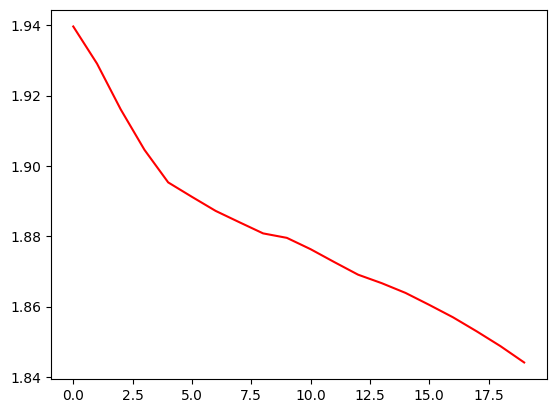

In [20]:
plt.plot(mean_loss,'r')